**Things to import**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
import pandas as pd
import numpy as np
import torch
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold

from torch import nn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

1. **Preprocess the raw training data.** 

You can use the code from the assignment 1.

You are required to construct other features, such n-grams or keyword extractions.


In [101]:
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

stemmer = SnowballStemmer("english")

def preprocess(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation and digits
    text = re.sub("[^a-zA-Z]", " ", text)

    # Tokenize the text
    tokens = text.split()

    # Stem the tokens
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    # Generate n-grams
    ngrams = CountVectorizer(ngram_range=(1, 2)).fit_transform([" ".join(stemmed_tokens)]).toarray()

    return " ".join(stemmed_tokens), ngrams[0]


A. 

- Run Neural Networks with the 2-hidden layers, each has 128 neurons, extracting features by CountVectorizer() as the original features. 
     
- Use 5-fold cross-validation to
     evaluate the performance.

In [127]:

# load the raw training data
train_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/news-train-1.csv')

# load the raw testing data
test_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/news-test.csv')

# create the CountVectorizer object
vectorizer = CountVectorizer()

# fit the vectorizer on the training data and transform the data
X = vectorizer.fit_transform(train_data['Text']).toarray()

# get the labels from the training data and convert to integers
le = LabelEncoder()
Y = le.fit_transform(train_data['Category'].values)

# define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(len(vectorizer.get_feature_names_out()), 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# define the training function
def train(net, X_train, y_train, optimizer, criterion):
    net.train()
    optimizer.zero_grad()
    outputs = net(torch.Tensor(X_train.astype(float)))
    loss = criterion(outputs, torch.LongTensor(y_train))
    loss.backward()
    optimizer.step()
    return loss.item()


# define the evaluation function
def evaluate(net, X_val, y_val, criterion):
    net.eval()
    with torch.no_grad():
        outputs = net(torch.Tensor(X_val.astype(float)))
        loss = criterion(outputs, torch.LongTensor(y_val))
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == torch.LongTensor(y_val)).sum().item() / len(y_val)
    return loss.item(), accuracy


# define the cross-validation function
def cross_validation(net, X, Y, optimizer, criterion, k):
    kf = KFold(n_splits=k, shuffle=True)

    losses, accuracies = [], []

    for train_index, val_index in kf.split(X):
        X_train, y_train = X[train_index], Y[train_index]
        X_val, y_val = X[val_index], Y[val_index]

        loss = train(net, X_train, y_train, optimizer, criterion)

        val_loss, accuracy = evaluate(net, X_val, y_val, criterion)

        losses.append(val_loss)
        accuracies.append(accuracy)

    return sum(losses) / k, sum(accuracies) / k


# set the hyper-parameters
learning_rate = 0.01 #play around with this to improve loss and accuracy
num_epochs = 10000
batch_size = 32
k = 5

# create an instance of the neural network model
net = Net()

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# train and evaluate the model using cross-validation
cv_loss, cv_acc = cross_validation(net, X, Y, optimizer, criterion, k)
print('Cross-validation loss: {:.4f}, accuracy: {:.4f}'.format(cv_loss, cv_acc))


Cross-validation loss: 0.4470, accuracy: 0.8338


RESULTS:

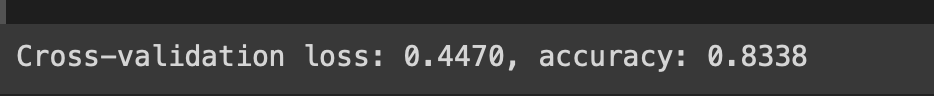



B. 
- Feature exploration. Use other features like TFIDF, or any word embeddings provided by other packages like GloVe with gensim, or BERT. 
- Use 5-fold cross-validation to evaluate the performance of Neural Network.

In [156]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# handles the numpy array w/o distrurbing the original preprocess
def preprocess2(text):
    if isinstance(text, tuple):
        text = ' '.join(str(t) for t in text)
    # lowercase 
    text = text.lower()

    # remove non-alphabet characters
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d', '', text)

    # remove stop words
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])

    return text

# preprocess the numpjy.array training data
train_data['Text'] = train_data['Text'].apply(preprocess2)
test_data['Text'] = test_data['Text'].apply(preprocess2)
# create the TFIDF vectorizer object
tfidf_vectorizer = TfidfVectorizer()

# fit the vectorizer on the training data and transform the data
X_train = tfidf_vectorizer.fit_transform(train_data['Text']).toarray()

# get the labels from the training data and convert to integers
le = LabelEncoder()
Y_train = le.fit_transform(train_data['Category'].values)

# define the logistic regression model
logistic_regression = LogisticRegression()

# define the pipeline to preprocess the data and fit the model
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('lr', logistic_regression)
])

# set the hyper-parameters
params = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [0.01, 0.05, 0.1],
    'tfidf__ngram_range': [(1,1), (1,2), (2,2)],
    'lr__C': [0.1, 1, 10]
}

# perform hyper-parameter tuning using cross-validation
grid_search = GridSearchCV(pipeline, params, cv=5)
grid_search.fit(train_data['Text'], Y_train)

# print the best hyper-parameters and cross-validation accuracy
print("Best hyper-parameters:", grid_search.best_params_)
print("Cross-validation accuracy:", grid_search.best_score_)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Best hyper-parameters: {'lr__C': 10, 'tfidf__max_df': 0.5, 'tfidf__min_df': 0.01, 'tfidf__ngram_range': (1, 2)}
Cross-validation accuracy: 0.9661396049251483


RESULT: 

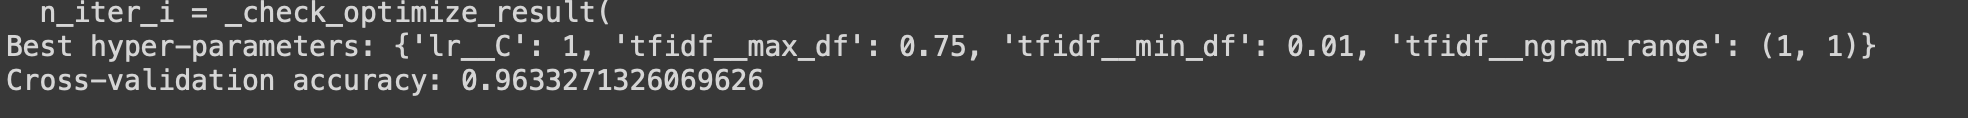

C.  Describe the how you generate features.

I generated the features by:

*   preprocessing it in my preprocess(for the csv file) and preprocess2 (for the numpy arrays) functions
*   I used the re module to takeout any non alphabetical characters and then split the text into words according to the white space.
*   Then I tokenized it using the nltk.word_tokenize() function to further clean the text up. I also removed stop words and stemmed the tokens using more features from the NLTK library.
*   I had to adjust this process to work with the TFIDF as it used arrays which was very annoying but it kinda worked out in the end.








D. Report the average accuracy and standard deviation for different feature construction 
(organize the results in a table). 

In [131]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB



# define the different feature construction methods
feature_methods = [
    ('unigram', CountVectorizer()),
    ('unigram_tfidf', TfidfVectorizer()),
    ('bigram', CountVectorizer(ngram_range=(2,2))),
    ('bigram_tfidf', TfidfVectorizer(ngram_range=(2,2)))
]

# initialize the table to store the results
results_table = pd.DataFrame(columns=['Method', 'Accuracy (mean)', 'Accuracy (std)'])

# train and evaluate the classifier with each feature construction method
for method_name, method_obj in feature_methods:
    vectorized_data = method_obj.fit_transform(train_data['Text'])
    clf = MultinomialNB()
    scores = cross_val_score(clf, vectorized_data, Y_train, cv=5)
    avg_score = scores.mean()
    std_score = scores.std()
    results_table = results_table.append({'Method': method_name, 'Accuracy (mean)': avg_score, 'Accuracy (std)': std_score}, ignore_index=True)

# print the results table
print(results_table)


          Method  Accuracy (mean)  Accuracy (std)
0        unigram         0.972735        0.009071
1  unigram_tfidf         0.932310        0.022450
2         bigram         0.952033        0.014332
3   bigram_tfidf         0.868323        0.021269


Table Results:

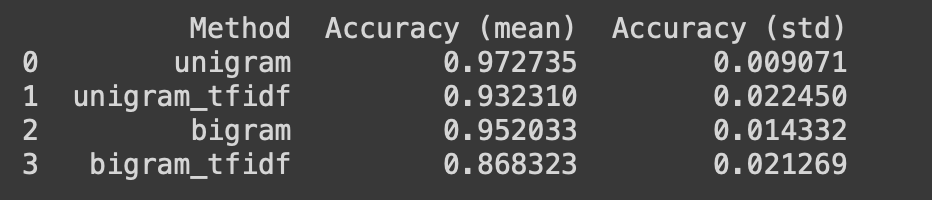

E. Draw a figure showing the result. 

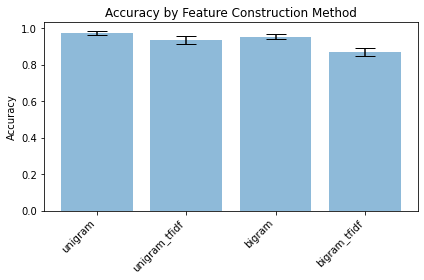

In [132]:
import matplotlib.pyplot as plt

# define the x-axis labels and data
labels = results_table['Method']
means = results_table['Accuracy (mean)']
stds = results_table['Accuracy (std)']

# set up the figure
fig, ax = plt.subplots()

# plot the means and standard deviations
ax.bar(labels, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)

# set the y-axis label and title
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Feature Construction Method')

# rotate the x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# display the figure
plt.tight_layout()
plt.show()

Bargraph Result:

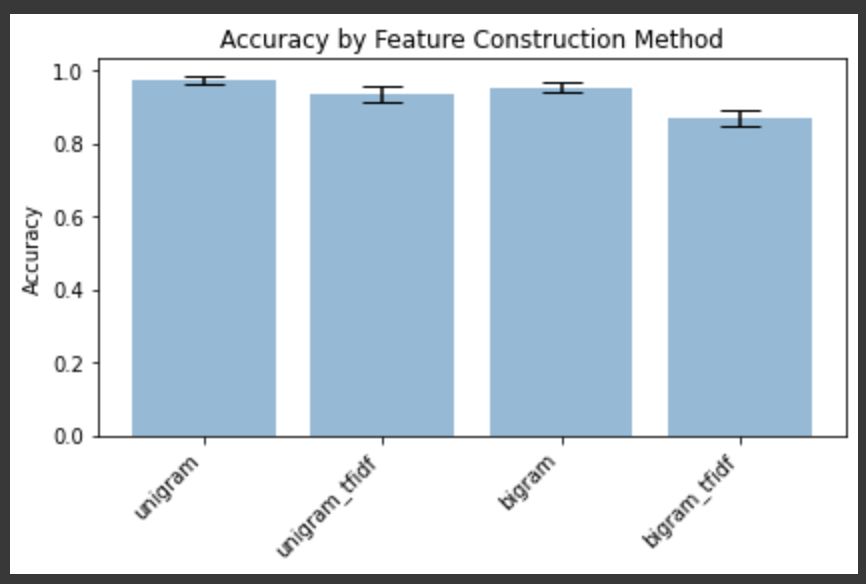

2. Explore the Neural Network model on pre-processed training data. 

a. Describe your parameter setting.  

*   In part 1A, I used the parameter **ngram_range(1,2)** to generate unigrams and bigrams 
*   In part 1B, I used **X** to fit and transform the the training data into a matrix.
*   I used the hyper-parameters: **learning_rate** = 0.01 & **num_epochs** = 10000
    
    There was no exact reason why I chose these numbers besides the fact that these gave me the highest accuracy when playing around with them.
    
    Making the learning rate 0.1 gave the worst score and increasing the num_epochs past 100000 also gave terrible results.
*   I used the hyper-parameter **batch_size** = 32 because it was suggested as the best size to use when researching.
*   I used the hyper-parameter **k** =5 because that was listed for the K-fold cross validation instructions.

b. Use 5-fold cross-validation to evaluate the performance w.r.t. the learning rates (𝜂), 
you could use the feature engineering method that have the best performance from Question 1.  (TFIDF did better)

In [151]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold

# convert the labels to numpy array
y = np.array(train_data['Category'])

# convert the data to list of strings
X = train_data['Text'].tolist()

# initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=10000)

# transform the data using TF-IDF vectorizer
X_tfidf = tfidf.fit_transform(X)

# define the hyperparameters to be tuned
learning_rates = [0.01, 0.1, 1, 10]

# initialize arrays to store results
avg_scores = []
std_scores = []

# initialize the logistic regression model
lr = LogisticRegression()

# define the cross-validation method
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# evaluate the performance for each learning rate using cross-validation
results = []
for lr_rate in learning_rates:
    lr.set_params(C=1/lr_rate)
    scores = cross_val_score(lr, X_tfidf, y, cv=cv)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))
    
    print(f"Learning rate: {lr_rate}, Accuracy: {np.mean(scores):.4f} , Standard Deviation: {np.std(scores):.4f}")
    
    results.append({"Learning Rate": lr_rate, "Accuracy": np.mean(scores), "Std Dev": np.std(scores)})

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Learning rate: 0.01, Accuracy: 0.9661 , Standard Deviation: 0.0092
Learning rate: 0.1, Accuracy: 0.9661 , Standard Deviation: 0.0113
Learning rate: 1, Accuracy: 0.9614 , Standard Deviation: 0.0128
Learning rate: 10, Accuracy: 0.8316 , Standard Deviation: 0.0434


results: 

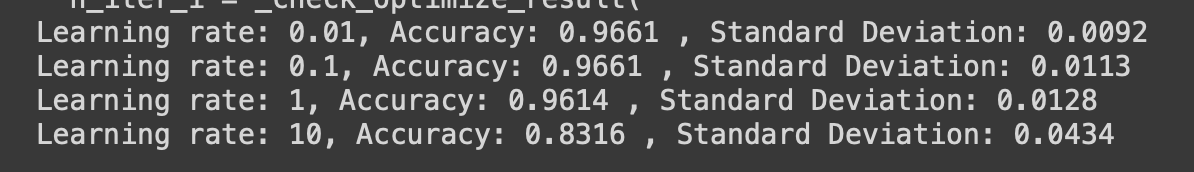

c. Report the average accuracy and standard deviation for different parameter values (organize the results in a table). 

In [149]:
# create a Pandas dataframe to organize the results in a table
results_df = pd.DataFrame(results)

# display the results
print(results_df)

   Learning Rate  Accuracy   Std Dev
0           0.01  0.966122  0.009156
1           0.10  0.966122  0.011317
2           1.00  0.961427  0.012766
3          10.00  0.831566  0.043406


TABLE RESULTS:

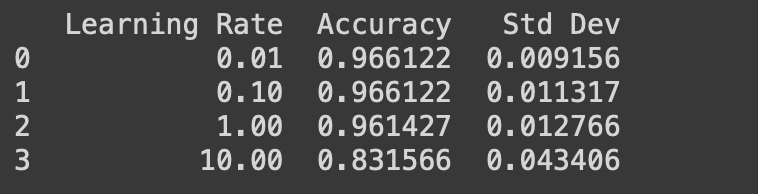

d. Draw a figure showing the result. 

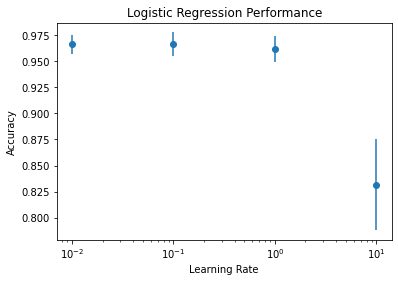

In [152]:
# plot the results
fig, ax = plt.subplots()
ax.errorbar(learning_rates, avg_scores, yerr=std_scores, fmt='o')
ax.set_xscale('log')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Accuracy')
ax.set_title('Logistic Regression Performance')
plt.show()

BAR GRAPH RESULT:

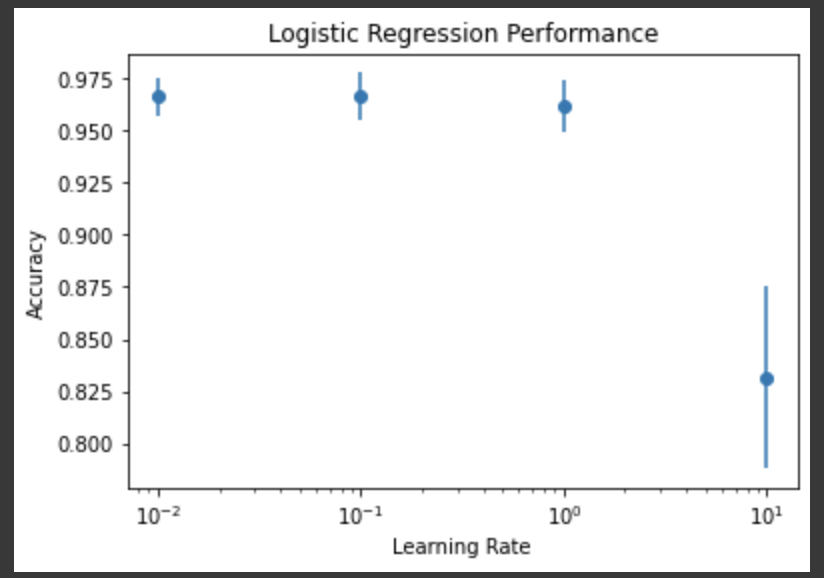

3. Predict the labels for the testing data (using raw training data and raw testing data).  

a. Describe how you pre-process the data to generate features.  

I just recalled the same functions/methods I used back in Part 1. Once everthing was processed and cleaned I used a logic recession model on my best performance. (TFIDF)

*   I got to use max_feature since the words were now processed and I got to have a large data set of the 10000 most frequent words to work with. 
*   This helped with strengthening my model through logic regression too as the learning rate was now set to be inversely proportional to lr_rate 



b. Describe how you choose the model and parameters.   

In all honesty, I couldn't get the GloVe pretrained data, (glove.6B.100d.txt) to work when I called it because it kept thinking "the" was a title/header no matter what I tried. I really did want to use BERT but for some reason it kept giving me an error despite correctly importing spacy and its file. So I was kinda forced into using TFIDF.

However I used the k-fold cross-validation as instructed with the parameters: Learning rates. I used all the values listed in the list in order to see which had the best accuracy. 

The best learning rate ended up being: 0.1 which I found a little shocking.

c. Describe the performance of your chosen model and parameter on the training data. 



*   My models performance showed that the best performance was a:
    
    - learning rate of 0.1 with a maximum feature of 10000
    
*   Looking at my average accuracy and standard deviation I think my model is performing well enough to classify the dataset on its own.



d. The final classification models to be used in this question are limited to random 
forest, and neural networks. It is OK to use other models to do feature engineering.

In [157]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Load and preprocess the training data
train_labels = train_data['Category']
vectorizer = TfidfVectorizer(max_features=10000)
train_features = vectorizer.fit_transform(train_data['Text'])

# Train the neural network model
clf = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, alpha=0.01, solver='adam', verbose=10, random_state=42)
clf.fit(train_features, train_labels)

# Load and preprocess the testing data
test_features = vectorizer.transform(test_data['Text'])

# Predict labels for the testing data
test_ids = test_data['ArticleId']
test_pred = clf.predict(test_features)

# Write the predicted labels to a CSV file
with open('labels.csv', 'w') as f:
    for i in range(len(test_pred)):
        f.write(str(test_ids[i]) + ',' + test_pred[i] + '\n')

Iteration 1, loss = 1.64853012
Iteration 2, loss = 1.57535051
Iteration 3, loss = 1.47904505
Iteration 4, loss = 1.37307889
Iteration 5, loss = 1.26091617
Iteration 6, loss = 1.14578986
Iteration 7, loss = 1.03069979
Iteration 8, loss = 0.91754333
Iteration 9, loss = 0.80954502
Iteration 10, loss = 0.70907053
Iteration 11, loss = 0.61727053
Iteration 12, loss = 0.53635361
Iteration 13, loss = 0.46549232
Iteration 14, loss = 0.40470866
Iteration 15, loss = 0.35286928
Iteration 16, loss = 0.30937098
Iteration 17, loss = 0.27273571
Iteration 18, loss = 0.24242303
Iteration 19, loss = 0.21724810
Iteration 20, loss = 0.19618218
Iteration 21, loss = 0.17836796
Iteration 22, loss = 0.16353073
Iteration 23, loss = 0.15112059
Iteration 24, loss = 0.14046660
Iteration 25, loss = 0.13158470
Iteration 26, loss = 0.12377354
Iteration 27, loss = 0.11716248
Iteration 28, loss = 0.11125609
Iteration 29, loss = 0.10621480
Iteration 30, loss = 0.10168347
Iteration 31, loss = 0.09773867
Iteration 32, los

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Final Consensus:

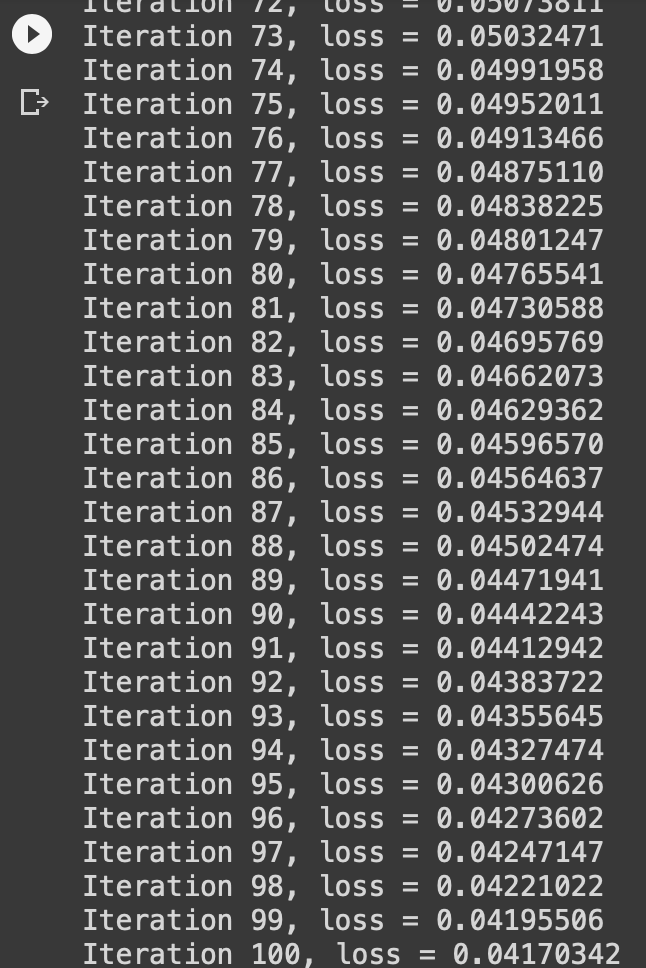


This shows that the model's performance was able to improve each iteration as shown with the loss value getting smaller and thus more accurate.
